<a href="https://colab.research.google.com/github/itsannapanna/kindofyeah/blob/main/TweetEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup


In [1]:
!pip install nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [3]:
def show_history(h):
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize = (16 , 6))

  plt.subplot(1,2,1)
  plt.plot(range(0 , epochs_trained) , h.history.get('accuracy') , label = 'Training')
  plt.plot(range(0 , epochs_trained) , h.history.get('val_accuracy') , label = 'Validation')
  plt.ylim([0. , 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(0 , epochs_trained) , h.history.get('loss') , label = 'Training')
  plt.plot(range(0 , epochs_trained) , h.history.get('val_loss') , label = 'Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


In [4]:
def show_confusion_matrix(y_true , y_pred , classes):
  from sklearn.metrics import confusion_matrix

  cm = confusion_matrix(y_true , y_pred , normalize = 'true')

  plt.figure(figsize = (8 , 8))
  sp = plt.subplot(1 , 1 , 1)
  ctx = sp.matshow(cm)
  plt.xticks(list(range(0,6)) , labels = classes)
  plt.yticks(list(range(0,6)) , labels = classes)
  plt.colorbar(ctx)
  plt.show()

### Importing Data

In [5]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")
label_mapping = {0: 'sadness', 1: 'joy', 2: 'love' , 3 : 'anger' , 4 : 'fear' , 5 : 'surprise'}

# numerical labels to text labels
dataset['train'] = [
    {'text': example['text'], 'label': label_mapping[example['label']]}
    for example in dataset['train']
]

print(dataset['train'][0])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': 'i didnt feel humiliated', 'label': 'sadness'}


In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets , labels

In [7]:
tweets , labels = get_tweet(train)

In [8]:
tweets[0] , labels[0]

('i didnt feel humiliated', 'sadness')

### Tokenization


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words = 10000 , oov_token = '<UKN>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

### Padding and truncating sequences

(array([  8.,  45., 310., 488., 539., 625., 626., 629., 613., 636., 654.,
        655., 608., 622., 609., 603., 559., 535., 530., 510., 452., 430.,
        382., 385., 330., 327., 336., 317., 238., 208., 200., 200., 167.,
        157., 141., 144., 120., 117., 117.,  88.,  96.,  72.,  66.,  66.,
         65.,  52.,  37.,  43.,  30.,  32.,  31.,  26.,  30.,  20.,  23.,
         14.,   9.,  10.,   4.,   4.,   4.,   1.,   4.,   1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.]),
 <BarContainer object of 64 artists>)

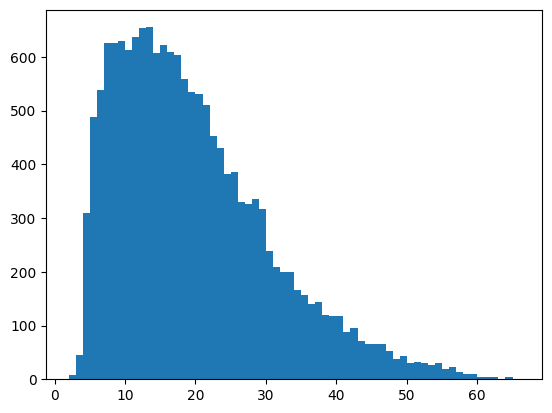

In [12]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths , bins = len(set(lengths)))

In [13]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer , tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences , truncating = 'post' , padding = 'post' , maxlen = maxlen)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer , tweets)

In [16]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing labels

In [17]:
classes = set(labels)
print(classes)

{'love', 'surprise', 'joy', 'anger', 'sadness', 'fear'}


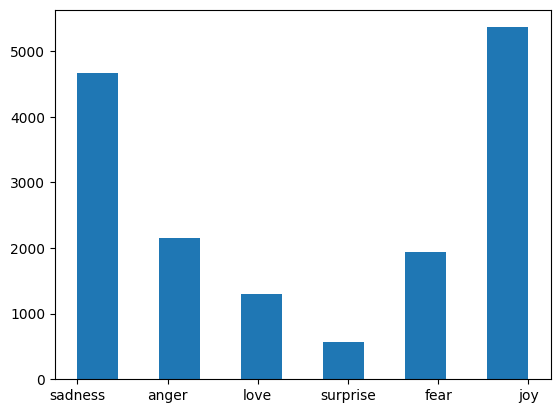

In [18]:
plt.hist(labels , bins = 11)
plt.show()

In [19]:
class_to_index = { 'sadness' : 0 , 'joy' : 1 ,'love' : 2 , 'anger':3, 'fear':4,'surprise' : 5}
index_to_class = {0 :('sadness'),
 1:('joy'),
 2:('love'),
 3:('anger'),
 4:('fear'),
 5:('surprise')}

In [20]:
class_to_index

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

In [21]:
index_to_class

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [22]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [23]:
train_labels = names_to_ids(labels)
train_labels

array([0, 0, 3, ..., 1, 3, 0])

### Creating model

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000 , 16 , input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20 , return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6 , activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']

)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the model
### Validation set prep

In [26]:
val_tweets , val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer , val_tweets)
print(val_labels)

[0, 0, 2, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1, 0, 3, 2, 1, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 3, 1, 2, 0, 0, 0, 3, 0, 0, 3, 2, 0, 0, 1, 1, 0, 1, 1, 3, 0, 0, 2, 2, 1, 0, 1, 1, 0, 0, 2, 4, 0, 1, 1, 1, 4, 2, 1, 0, 3, 0, 0, 0, 3, 3, 0, 3, 2, 1, 1, 2, 3, 3, 1, 2, 3, 4, 1, 3, 3, 2, 0, 3, 2, 2, 0, 1, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 3, 3, 3, 1, 0, 2, 4, 4, 1, 0, 4, 0, 0, 1, 3, 0, 4, 4, 2, 1, 1, 0, 1, 0, 1, 3, 5, 2, 4, 2, 0, 2, 1, 4, 3, 1, 3, 1, 5, 3, 2, 0, 4, 3, 1, 0, 1, 5, 1, 4, 4, 0, 0, 5, 0, 1, 4, 1, 4, 0, 2, 2, 0, 3, 3, 1, 1, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 3, 0, 4, 1, 0, 1, 3, 3, 1, 4, 0, 4, 1, 1, 0, 0, 0, 1, 5, 4, 0, 0, 1, 5, 0, 4, 0, 5, 4, 1, 3, 4, 1, 1, 3, 5, 1, 2, 1, 1, 4, 1, 2, 4, 0, 0, 0, 1, 1, 5, 3, 2, 1, 1, 4, 1, 1, 0, 0, 3, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 4, 0, 5, 1, 2, 1, 3, 0, 1, 4, 3, 4, 2, 2, 1, 4, 0, 4, 0, 0, 3, 0, 4, 3, 0, 1, 0, 2, 1, 1, 4, 1, 1, 0, 1, 0, 5, 4, 3, 4, 1, 1, 3, 1, 2, 

In [27]:
val_tweets[0] , val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [28]:
padded_train_seq = np.array(padded_train_seq)

# Assuming train_labels is a numpy array
val_labels = np.array(val_labels)

h = model.fit(
    padded_train_seq , train_labels,
    validation_data = (val_seq , val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience = 2 )
    ]
)

Epoch 1/20
500/500 [==============================] - 58s 89ms/step - loss: 1.3099 - accuracy: 0.4866 - val_loss: 0.9162 - val_accuracy: 0.6740
Epoch 2/20
500/500 [==============================] - 30s 61ms/step - loss: 0.5909 - accuracy: 0.7831 - val_loss: 0.5592 - val_accuracy: 0.8105
Epoch 3/20
500/500 [==============================] - 31s 61ms/step - loss: 0.3238 - accuracy: 0.8906 - val_loss: 0.4388 - val_accuracy: 0.8630
Epoch 4/20
500/500 [==============================] - 33s 65ms/step - loss: 0.2043 - accuracy: 0.9337 - val_loss: 0.4025 - val_accuracy: 0.8795
Epoch 5/20
500/500 [==============================] - 31s 61ms/step - loss: 0.1480 - accuracy: 0.9533 - val_loss: 0.3981 - val_accuracy: 0.8775
Epoch 6/20
500/500 [==============================] - 31s 63ms/step - loss: 0.1171 - accuracy: 0.9632 - val_loss: 0.4339 - val_accuracy: 0.8780


### Evaluation

Visualizing training history

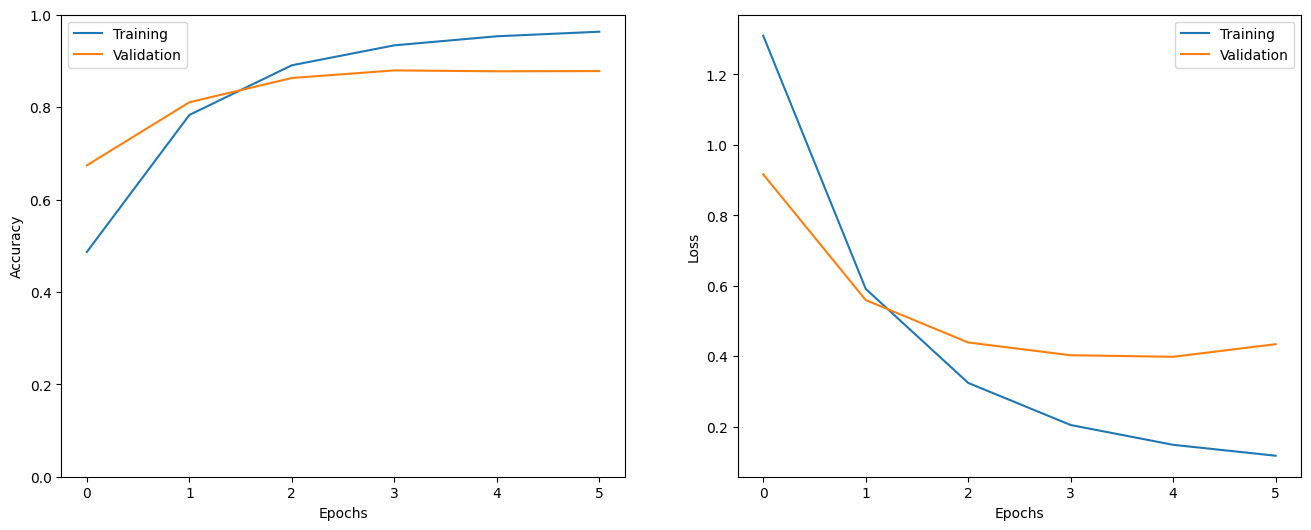

In [29]:
show_history(h)

prepping test set

In [30]:
test_tweets , test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer , test_tweets)
test_labels[6]

3

individual predictions

In [31]:
dataset['test'] = [
    {'text': example['text'], 'label': label_mapping[example['label']]}
    for example in dataset['test']
]

In [32]:
test_labels = np.array(test_labels)
_ = model.evaluate(test_seq , test_labels)

63/63 [==============================] - 1s 15ms/step - loss: 0.4047 - accuracy: 0.8775


In [33]:
dataset['test'][0]
labels[0]

'sadness'

In [34]:
i = random.randint(0 , len(test_labels) - 1)

print('Sentence:' , test_tweets[i])
print('Emotion:' , index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i] , axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion: ' , pred_class)

Sentence: i feel they are one of the most talented teams in the nfl but for some reason people feel like there s nothing to really fear against them
Emotion: joy
1/1 [==============================] - 2s 2s/step
Predicted Emotion:  joy


In [35]:
preds = np.argmax(model.predict(test_seq), axis=1)

63/63 [==============================] - 1s 14ms/step


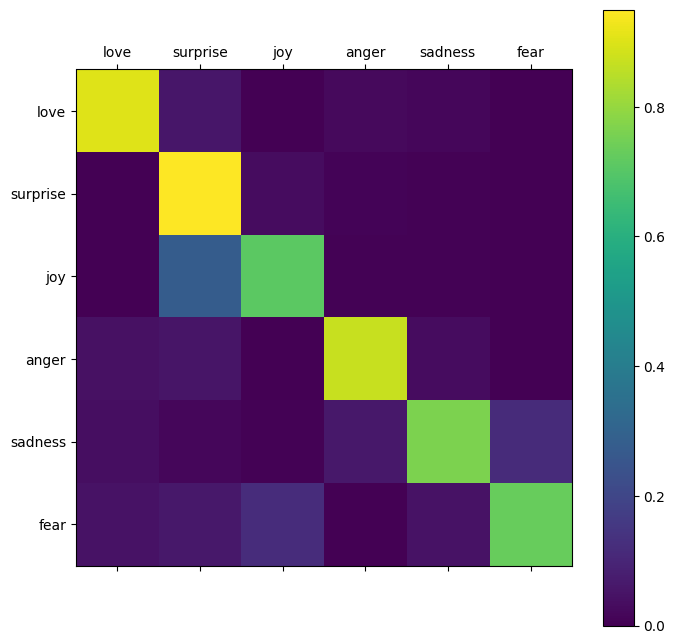

In [36]:
show_confusion_matrix(test_labels , preds , list(classes))